In [38]:
%%sh
sudo apt install fonts-cmu texlive-latex-extra cm-super dvipng
mkdir out

In [1]:
import copy
from functools import partial
from typing import *

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import wandb
import wandb.apis

api = wandb.Api()

sns.set_context("paper", font_scale=1.5)
matplotlib.rc('font', **{'family': 'serif', 'serif': ["CMU Serif"]})
matplotlib.rc('text', usetex=True)
matplotlib.font_manager.findfont("CMU Serif", rebuild_if_missing=True)

'/usr/share/fonts/truetype/cmu/cmunrm.ttf'

In [2]:
def load_one(run: wandb.apis.public.Run) -> Dict[str, Any]:
    if "count" in run.summary and run.notes != "buggy" and run.id != "dt7fl1ho":
        task = run.config["task"]["name"]
        mc = run.summary["model_config"]
        score_key = dict(
            squad="match",
            triviaqa="match",
            cnn_dailymail="rougeL",
            wikitext_bpc="bpc",
            repetition="match_length_char",
        )[task]
        sparsity = copy.deepcopy(run.config["sparsity"])
        assert sparsity.pop("score", None) in [None, "sparse_q"]
        scores = [r[score_key] for r in run.summary["results"]]
        return dict(
            id=run.id,
            task=task,
            model=run.config["model"].split("/")[1].replace("-hf", "").lower(),
            n_heads=mc["num_attention_heads"] * mc["num_hidden_layers"],
            head_size=mc["hidden_size"]//mc["num_attention_heads"],
            **sparsity,
            prefill_length=run.summary["prefill_length"],
            score=np.mean(scores),
            score_stderr=np.sqrt(np.var(scores) / len(scores)),
        )

def load_sweep(experiment_name: str, *single_runs: str) -> pd.DataFrame:
    return pd.DataFrame.from_dict(filter(None, (
        load_one(run)
        for run in api.runs(
            "research/sparse-attention", {"$or": [
                {"config.name": experiment_name},
                *({"display_name": n} for n in single_runs)
            ]}
        )
    )))

def memory_transfers_attention_only(s: pd.Series, count_kv: bool = True, count_index: bool = True) -> int:
    kv_elements, index_elements = 0, 0  # per-head
    if s["name"] == "dense":
        # write 1*(k, v) + read all prefill_length*(k, v)
        kv_elements = (2 + 2 * s["prefill_length"]) * s["head_size"]

    elif s["name"] == "sparse_v":
        # write 1*(k, v) + read all prefill_length*k + read sparse_k*v
        kv_elements = (2 + s["prefill_length"] + s["k"]) * s["head_size"]

    elif s["name"] == "local":
        # write 1*(k, v) + read sparse_k*v
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]

    elif s["name"] == "eviction":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]
        # read/write scores
        index_elements = (1 + 2 * s["prefill_length"])

    elif s["name"] == "ann":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]
        # read/write index
        index_elements = s["head_size"] + s["prefill_length"] * s["rank"]
        if s["reallocate_to_mean_value"]:
            #  read/write mean_v
            index_elements += 2 * s["head_size"]

    else:
        assert False, s["name"]

    return (count_kv * kv_elements + count_index * index_elements) * s["n_heads"]

def add_dense_as_sparse(df: pd.DataFrame) -> pd.DataFrame:
    """Add 'dense' as if it were a sparse technique.
    Note that this only gives it the sparse 'name' string (not k, etc).
    """
    def _map(g: pd.DataFrame) -> pd.DataFrame:
        g_dense = g[g["name"]=="dense"]
        assert len(g_dense) == 1
        return (g.groupby("name")
                .apply(lambda gg: gg if gg.name=="dense" else pd.concat([gg, g_dense.assign(name=gg.name)]))
                .reset_index(drop=True))
    return df.groupby(["task", "model"]).apply(_map).reset_index(drop=True)

df = (
    load_sweep("RMOE-68-workshop-sweep")
    .pipe(lambda d: d.assign(transfers=d.apply(memory_transfers_attention_only, axis=1)))
    .pipe(lambda d: d[d["model"] != "llama-2-13b"])
    [["task", "model", "name", "k", "rank", "transfers", "score", "score_stderr", "id"]]
)

palette = sns.color_palette()
name_to_hue = dict(dense=palette[4], ann=palette[0], eviction=palette[2], local=palette[3])
name_to_marker = dict(dense=".", ann="o", eviction="X", local="^")

# Standard error

task
cnn_dailymail    0.004206
repetition       2.588735
squad            0.007558
triviaqa         0.008702
wikitext_bpc     0.006147
dtype: float64

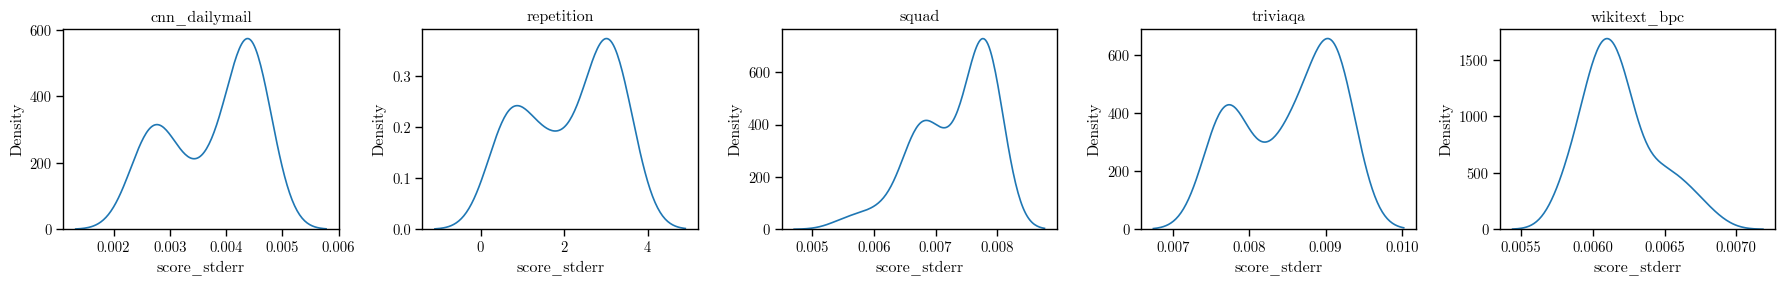

In [67]:
_, axs = plt.subplots(1, 5, figsize=(18, 3))
for ax, (task, g) in zip(axs, df.pipe(lambda d: d[d.model.isin(["llama-2-7b", "pythia-6.9b"])]).groupby("task")):
    sns.kdeplot(g.score_stderr, ax=ax)
    ax.set_title(task)
plt.tight_layout()
display(df.pipe(lambda d: d[d.model.isin(["llama-2-7b", "pythia-6.9b"])]).groupby("task").apply(lambda d: d.score_stderr.median()))

# Typical compression

In [99]:
def get_compression(df: pd.DataFrame) -> pd.DataFrame:
    dense = df[df["name"]=="dense"]
    assert len(dense) == 1
    # return float(dense.transfers)
    dense_transfers = float(dense.transfers.iloc[0])
    return df.groupby(["name", "k", "rank"], dropna=False).apply(lambda d: d.assign(compression=d.transfers/dense_transfers)).reset_index(drop=True)

dfc = df.pipe(lambda d: d[d.model.isin(["llama-2-7b", "pythia-6.9b"])]).groupby(["model", "task"], dropna=False).apply(get_compression).reset_index(drop=True)

(dfc.groupby(["name", "rank", "k"], dropna=False)
.apply(lambda d: pd.Series(dict(compression_ratio=f"{d.compression.min():.2f}-{d.compression.max():.2f}")))
)

compression_ratio
name     rank k                      
ann      16.0 64.0          0.10-0.12
              128.0         0.13-0.17
         32.0 64.0          0.16-0.18
              128.0         0.19-0.23
         64.0 64.0          0.28-0.30
              128.0         0.31-0.36
dense    NaN  NaN           1.00-1.00
eviction NaN  128.0         0.07-0.11
              192.0         0.10-0.17
              256.0         0.13-0.22
              384.0         0.20-0.33
              512.0         0.26-0.43
              768.0         0.39-0.65
local    NaN  128.0         0.06-0.11
              192.0         0.09-0.16
              256.0         0.13-0.21
              384.0         0.19-0.32
              512.0         0.25-0.43
              768.0         0.38-0.64

In [69]:
d = (df.groupby(["model", "task", "name", "k", "rank"], dropna=False).apply(lambda d: d.assign(n=len(d))))
d[d.n>1]

task       model   name      k  rank   
model      task  name  k     rank                                              
llama-2-7b squad local 128.0 NaN  145  squad  llama-2-7b  local  128.0   NaN  \
                                  156  squad  llama-2-7b  local  128.0   NaN   
                       192.0 NaN  144  squad  llama-2-7b  local  192.0   NaN   
                                  150  squad  llama-2-7b  local  192.0   NaN   
                       256.0 NaN  142  squad  llama-2-7b  local  256.0   NaN   
                                  155  squad  llama-2-7b  local  256.0   NaN   
                       384.0 NaN  140  squad  llama-2-7b  local  384.0   NaN   
                                  149  squad  llama-2-7b  local  384.0   NaN   
                       512.0 NaN  137  squad  llama-2-7b  local  512.0   NaN   
                                  154  squad  llama-2-7b  local  512.0   NaN   
                       768.0 NaN  135  squad  llama-2-7b  local  768.0   NaN   
                                  148  squad  llama-2-7b  local  768.0   NaN   

                                         transfers    score  score_stderr   
model      task  name  k     rank                                           
llama-2-7b squad local 128.0 NaN  145   33816576.0  0.22850      0.006639  \
                                  156   33816576.0  0.22850      0.006639   
                       192.0 NaN  144   50593792.0  0.25525      0.006894   
                                  150   50593792.0  0.25500      0.006892   
                       256.0 NaN  142   67371008.0  0.28300      0.007122   
                                  155   67371008.0  0.28300      0.007122   
                       384.0 NaN  140  100925440.0  0.32750      0.007420   
                                  149  100925440.0  0.32800      0.007423   
                       512.0 NaN  137  134479872.0  0.37600      0.007659   
                                  154  134479872.0  0.37600      0.007659   
                       768.0 NaN  135  201588736.0  0.46125      0.007882   
                                  148  201588736.0  0.46150      0.007882   

                                             id  n  
model      task  name  k     rank                   
llama-2-7b squad local 128.0 NaN  145  6yyjr6bd  2  
                                  156  b13nchiu  2  
                       192.0 NaN  144  rhc29d4t  2  
                                  150  6m2q6445  2  
                       256.0 NaN  142  zxx2sozm  2  
                                  155  h6fqzpfe  2  
                       384.0 NaN  140  2wkr7waq  2  
                                  149  ter88pbf  2  
                       512.0 NaN  137  usom8nfu  2  
                                  154  qvosh7wd  2  
                       768.0 NaN  135  bqyw9zrv  2  
                                  148  n6bpu4si  2

# Trade-off (Main & Appendix)

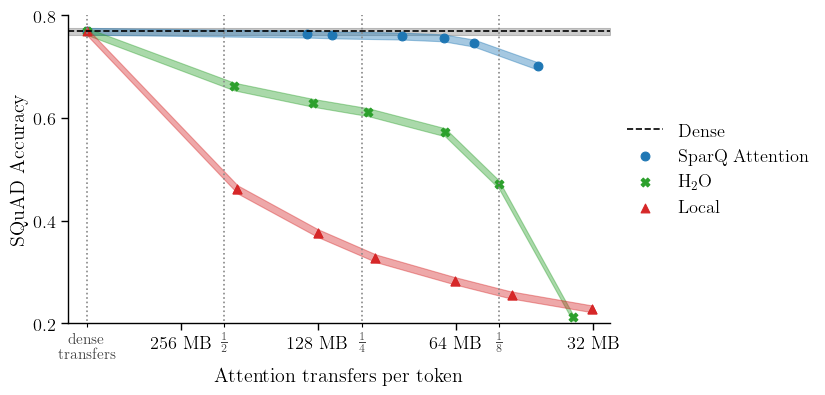

In [3]:
def show_tradeoff(model: str, task: str, title: bool, xlabel: bool, ylabel: bool, model_label: bool,
                  vlines: List[float], vlineslabel: bool,
                  ax: matplotlib.axes.Axes) -> None:
    g = add_dense_as_sparse(df[(df.model == model)&(df.task == task)])
    dense = g[g.name=="dense"].iloc[0]
    rmin, rmax = dict(
        squad=(.5, 1.05),
        cnn_dailymail=(.5, 1.05),
        triviaqa=(.5, 1.05),
        wikitext_bpc=(1.25, 1/1.025),
        repetition=(0, 1.1),
    )[task]
    score_min, score_max = dense.score * rmin, dense.score * rmax
    transfers_min, transfers_max = dense.transfers * 1.1, dense.transfers / 14
    lo = dense.score - dense.score_stderr
    hi = dense.score + dense.score_stderr
    ax.fill_between([transfers_min, transfers_max], [lo, lo], [hi, hi], color="k", alpha=.2)
    ax.hlines(dense.score, transfers_min, transfers_max, "k", linestyles="--", label="Dense")
    for ratio in vlines:
        ax.vlines(dense.transfers / ratio, 0, g.score.max() * 2, "k", linestyles=":", color="#888")

    for name, hue in name_to_hue.items():
        if name != "dense":
            d = g[g.name == name].sort_values("transfers")
            ax.fill_between(d.transfers, d.score - d.score_stderr, d.score + d.score_stderr, color=hue, alpha=.4)
            ax.scatter(d.transfers, d.score, color=hue, label=dict(ann="SparQ Attention", eviction="H$_2$O", local="Local")[name],
                        marker=name_to_marker[name], s=40)
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(lambda x, _: f"{x/2**20:.0f} MB" if 2**20 <= x else f"1/{1/(x/2**20):.0f} MB")
    ax.set_xlim((transfers_min, transfers_max))
    ax.set_ylim((score_min, score_max))
    ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=5, steps=[1,2,3,5,10]))
    if vlineslabel:
        assert vlines[0] == 1
        ax.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator([dense.transfers / ratio for ratio in vlines]))
        ax.tick_params(axis="x", which="minor", bottom=True, labelbottom=True, labelsize=11, labelcolor="#444")
        labels = ["dense\ntransfers"] + [f"$\\frac{{1}}{{{ratio}}}$" for ratio in vlines[1:]]
        ax.xaxis.set_minor_formatter(lambda _, n: labels[n])
    if title:
        ax.set_title(model.capitalize().replace("b", "B"), pad=12)
    if xlabel:
        ax.set_xlabel("Attention transfers per token")
    if model_label:
        ax.annotate(model, [transfers_min, score_min],
                    xytext=(5, 5), textcoords="offset points", va="bottom", ha="left", fontsize=12, alpha=.75)
    if ylabel:
        ax.set_ylabel(dict(squad="SQuAD Accuracy", cnn_dailymail="CNN/DailyMail ROUGE-L", triviaqa="TriviaQA Accuracy",
                           wikitext_bpc="WikiText-103 BPC", repetition="Repetition match length")[task])
    sns.despine(ax=ax)

sns.set_context("paper", font_scale=1.5)
plt.figure(figsize=(7, 4))
ax = plt.gca()
show_tradeoff("llama-2-7b", "squad", title=False, xlabel=True, ylabel=True, model_label=False, vlines=[1, 2, 4, 8], vlineslabel=True, ax=ax)
ax.legend(frameon=False, bbox_to_anchor=(1.0, 0.5), loc="center left")
ax.set_ylim((0.2, 0.8))
plt.savefig(f"out/tradeoff_llama_squad.pdf", bbox_inches="tight")

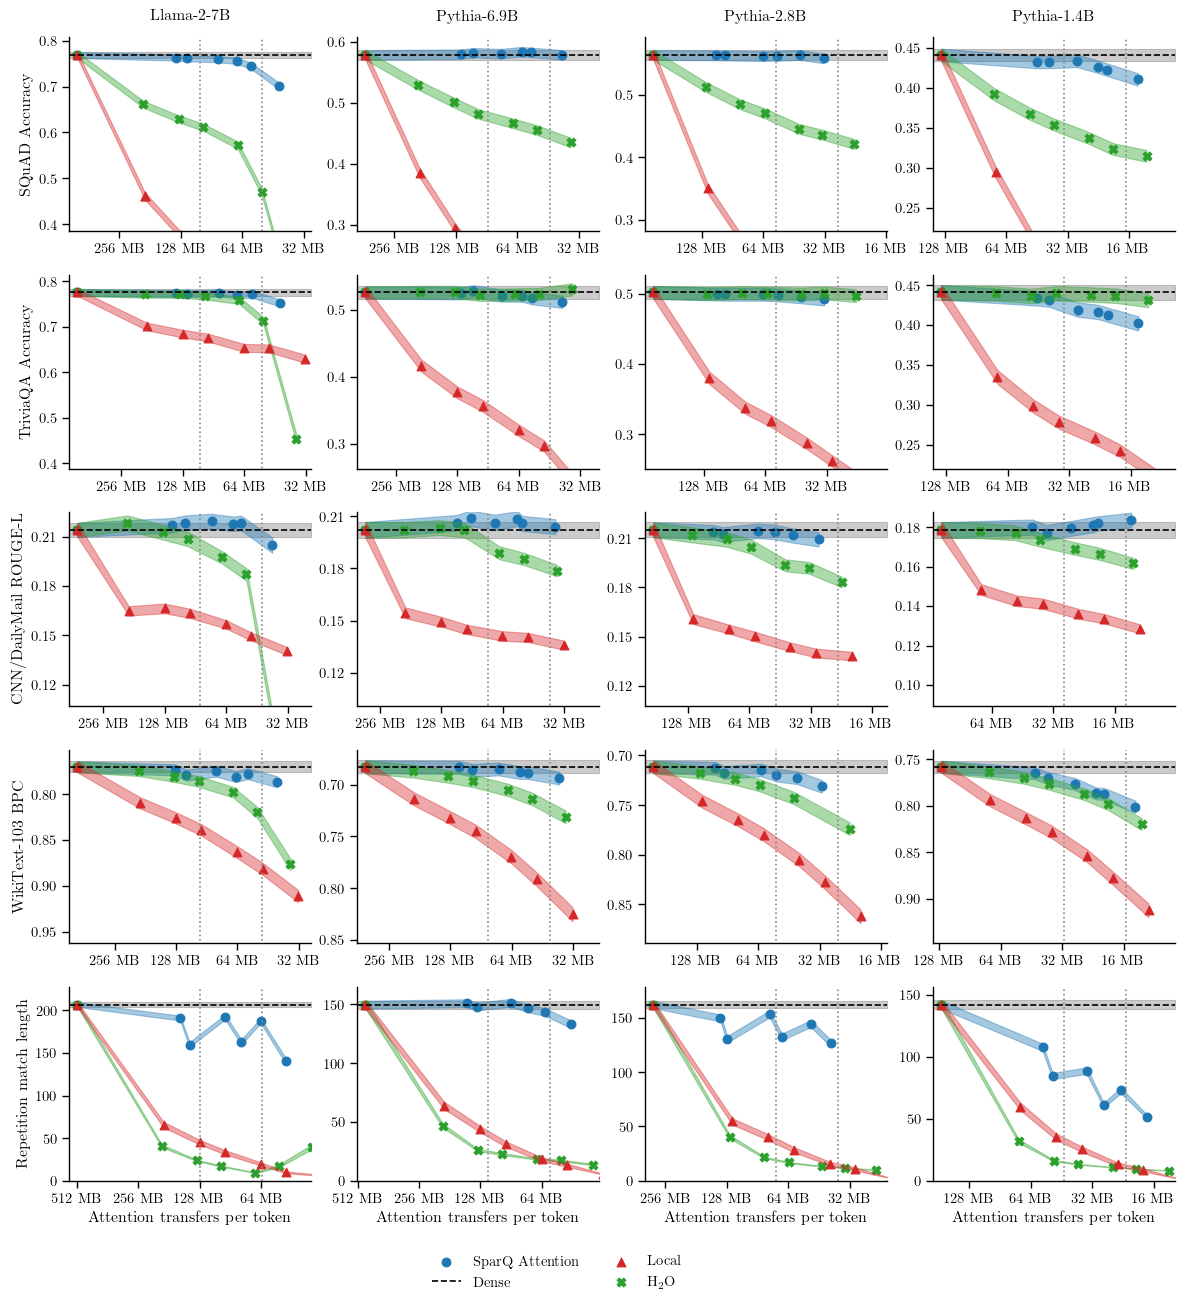

In [4]:
def show_tradeoffs(models: List[str], tasks: List[str], size: Tuple[float, float]) -> np.ndarray:
    fig, axs = plt.subplots(len(models), len(tasks), figsize=(size[0]*len(tasks), size[1]*len(models)), squeeze=False)
    for model, axr in zip(models, axs):
        for task, ax in zip(tasks, axr):
            show_tradeoff(model, task, title=(model==models[0]), xlabel=(model==models[-1]), model_label=True, vlines=[4, 8], vlineslabel=False, ax=ax)
    plt.tight_layout(w_pad=0.5)
    fig.legend(*axs[0, 0].get_legend_handles_labels(), frameon=False, bbox_to_anchor=(1.0, 0.5), loc="center left")
    return axs

def show_tradeoffs(models: List[str], tasks: List[str], size: Tuple[float, float]) -> np.ndarray:
    fig, axs = plt.subplots(len(tasks), len(models), figsize=(size[0]*len(models), size[1]*len(tasks)), squeeze=False)
    for task, axr in zip(tasks, axs):
        for model, ax in zip(models, axr):
            # show_tradeoff(model, task, title=(model==models[0]), xlabel=(model==models[-1]), model_label=True, vlines=[4, 8], vlineslabel=False, ax=ax)
            show_tradeoff(model, task, title=(task == tasks[0]), xlabel=(task == tasks[-1]), ylabel=(model == models[0]), model_label=False, vlines=[4, 8], vlineslabel=False, ax=ax)
    plt.tight_layout(w_pad=0.5)
    fig.legend(*axs[0, 0].get_legend_handles_labels(), frameon=False,
            #    bbox_to_anchor=(0.98, 0.5), loc="center left")
               mode="expand",
               ncols=2, reverse=True,
               bbox_to_anchor=(0.5, 0.0), loc="upper center")
    return axs

sns.set_context("paper", font_scale=1.2)
show_tradeoffs(["llama-2-7b", "pythia-6.9b", "pythia-2.8b", "pythia-1.4b"],
               ["squad", "triviaqa", "cnn_dailymail", "wikitext_bpc", "repetition"], (3, 2.5));
plt.savefig("out/tradeoff_grid.pdf", bbox_inches="tight")

# (Appendix) Model IDs for example outputs

In [ ]:
{task: list(g
    .pipe(lambda d: d[d.model == "llama-2-7b"])
    .pipe(lambda d: d[d.apply(lambda s: s["name"]=="dense" or (s["name"]=="ann" and s["rank"] == 16 and s["k"] == 64) or (s["name"] in ["eviction", "local"] and s["k"] == 192), axis=1)])
    .groupby("name").apply(lambda d: d.iloc[0])  # multiple "local" runs
    .id
    )
for task, g in df.groupby("task")}

{'cnn_dailymail': ['vwnh8cu6', '539f9rom', '82e0zahq', 'lbpj144w'],
 'repetition': ['wez29r4a', '3myiq6s1', 'tyhsk7u3', '4kuqkuvs'],
 'squad': ['u65h4c6x', 's73en2vc', 'tiv7kxft', 'rhc29d4t'],
 'triviaqa': ['cjcx2ccn', 'h08zynp0', 's3har2ni', 'i1klec42'],
 'wikitext_bpc': ['xxlf2lqq', 'z1fclt4r', 'nwepshqs', 'zelxigof']}

# Graveyard

## Normalised curves

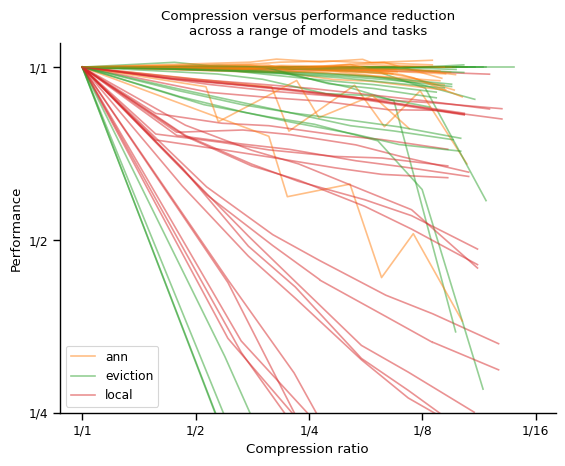

In [ ]:
ax = plt.gca()
label = True
for (model, task), g in add_dense_as_sparse(df).groupby(["model", "task"]):
    dense = g[g["name"] == "dense"].iloc[0]
    for name in name_to_hue:
        if name != "dense":
            d = g[g["name"] == name]
            ax.plot(
                "compression", "score",
                data=d.assign(score=dense["score"] / d["score"] if task == "wikitext_bpc" else d["score"] / dense["score"],
                            compression=d["transfers"] / dense["transfers"]).sort_values("compression"),
                color=name_to_hue[name], alpha=.5, label=name if label else "_nolabel")
    label=False
ax.legend()
ax.invert_xaxis()
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=2)
ax.xaxis.set_major_formatter(lambda x, _: f"1/{int(1/x)}")
ax.yaxis.set_major_formatter(lambda x, _: f"1/{int(1/x)}")
ax.set_xlabel("Compression ratio")
ax.set_ylabel("Performance")
ax.set_ylim((1/4, 1.1))
ax.set_title("Compression versus performance reduction\nacross a range of models and tasks")
sns.despine(ax=ax)

## 1/8 transfer

In [142]:
def lerp(df: pd.DataFrame, col: str, threshold: float) -> pd.Series:
    t = df[col]
    if 1 <= (t <= threshold).sum() and 1 <= (t > threshold).sum():
        lo = df.loc[t[t <= threshold].idxmax()]
        hi = df.loc[t[t > threshold].idxmin()]
        wlo = (hi[col] - threshold) / (hi[col] - lo[col])
        return pd.Series({
            k: lo[k] if isinstance(lo[k], str) else wlo * lo[k] + (1-wlo) * hi[k]
            for k in lo.keys()
        })

def lerp_to_compression_ratio(df: pd.DataFrame, ratio: float) -> pd.DataFrame:
    threshold = df[(df["name"]=="dense")].transfers.item() * ratio
    return df[df["name"]!="dense"].groupby("name").apply(lambda g: lerp(g, "transfers", threshold)).reset_index(drop=True)

d = pd.concat(
    [df.groupby(["model", "task"]).apply(lambda g: lerp_to_compression_ratio(g, ratio=1/8)).reset_index(drop=True),
     df[df["name"]=="dense"]]
)
for model in ["llama-2-7b", "pythia-6.9b"]:
    display(d.drop(columns=["k", "rank", "transfers", "score_stderr"])
        .pipe(lambda d: d[d.model.isin([model])])
        .dropna()
        .pivot(index=["task"], columns="name", values="score")
        .reset_index()
        [["task", "dense", "ann", "eviction", "local"]]
        .pipe(lambda d: d.loc[d.task.apply(["squad", "triviaqa", "cnn_dailymail", "wikitext_bpc", "repetition"].index).argsort()])
        .rename_axis(columns=model)
        .style.format(lambda x: x if isinstance(x, str) else (f"{x:.1f}" if x > 1 else f"{x:.3f}"))
    )

llama-2-7b,task,dense,ann,eviction,local
2,squad,0.769,0.727,0.470,0.261
3,triviaqa,0.776,0.764,0.716,0.653
0,cnn_dailymail,0.214,0.209,0.130,0.146
4,wikitext_bpc,0.770,0.782,0.829,0.881
1,repetition,206.9,185.6,11.9,19.4


pythia-6.9b,task,dense,ann,eviction,local
2,squad,0.578,0.580,0.446,0.164
3,triviaqa,0.526,0.514,0.526,0.285
0,cnn_dailymail,0.202,0.204,0.180,0.138
4,wikitext_bpc,0.683,0.692,0.724,0.805
1,repetition,149.8,141.3,17.9,16.5
